In [1]:
import tensorflow as tf

In [2]:
BATCH_SIZE = 10
IMAGE_SIZE = 256
classes  = 2
EPOCHS = 50

In [3]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    'cancer_data',
    shuffle=True,
    seed = 123,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

Found 253 files belonging to 2 classes.


In [4]:
classes_name = data.class_names
classes_name

['no', 'yes']

tf.Tensor([1 1 0 0 1 1 0 1 1 0], shape=(10,), dtype=int32)


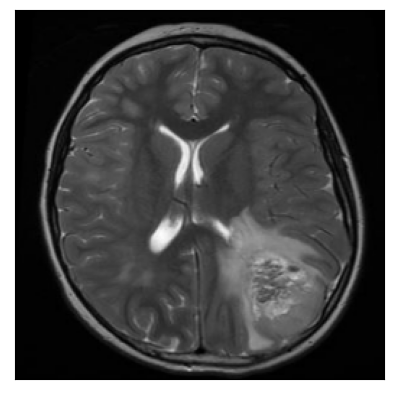

In [5]:
import matplotlib.pyplot as plt
import numpy as np

for image_batch, label_batch in data.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    print(label_batch)
    plt.xticks([])
    plt.yticks([])

In [6]:
def split_data(data, train_size=0.8, test_size=0.1, valid_size=0.1, buffer_size=5000, shuffle=True):
    if shuffle:
        data = data.shuffle(buffer_size, seed=123)

    count_data = 0
    for _ in data:
        count_data += 1

    train_count = round(train_size * count_data)
    test_count = round(test_size * count_data)
    valid_count = count_data - train_count - test_count  # Ensure total adds up

    if shuffle:
        data = data.shuffle(buffer_size, seed=123)

    train_data = data.take(train_count)
    test_data = data.skip(train_count).take(test_count)
    valid_data = data.skip(train_count + test_count).take(valid_count)

    return train_data, test_data, valid_data


In [7]:
train_size, test_size, valid_size = split_data(data)


In [8]:
len(data)

26

In [9]:
len(train_size)

21

In [10]:
0.8*26

20.8

Now we apply data augumentation

In [11]:
resize_rescaling = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./ 255)
])

In [12]:
# Caches the dataset in memory after the first epoch,

# 2. shuffle(10000)
# What it does: Randomly shuffles the elements of the dataset using a buffer of size 10,000.

# Why it's useful: Helps prevent the model from learning any unintended order in the data.

# Note: The buffer size (10,000) means TensorFlow fills a buffer with 10,000 elements, then randomly picks elements from that buffer.


# 3. prefetch(buffer_size=tf.data.AUTOTUNE)
# What it does: Allows data loading to happen in the background while the model is training or evaluating.

# tf.data.AUTOTUNE lets TensorFlow automatically choose the best prefetch buffer size based on your system.

In [13]:
train_size = train_size.cache().shuffle(5000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_size = test_size.cache().shuffle(5000).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_size = valid_size.cache().shuffle(5000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.3),
])

In [15]:
# n_classes = 2
# input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape=input_shape),
#     resize_rescaling,
#     data_augmentation,
#     tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
#     tf.keras.layers.MaxPooling2D((2,2)),
#     tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
#     tf.keras.layers.MaxPooling2D((2,2)),
#     tf.keras.layers.Conv2D(120, (3,3), activation = 'relu'),
#     tf.keras.layers.MaxPooling2D((2,2)), 
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(n_classes, activation='sigmoid'),
    
# ])
n_classes = 1
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    resize_rescaling,
    data_augmentation,

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                  

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [18]:
# Add Learning Rate Scheduler
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

In [19]:
history = model.fit(
    train_size,
    epochs = 30,
    batch_size = BATCH_SIZE,
    callbacks=callbacks,
    validation_data = valid_size,
)

Epoch 1/30


21/21 [==============================] - 35s 1s/step - loss: 0.6800 - accuracy: 0.5476 - auc: 0.5733 - val_loss: 0.6128 - val_accuracy: 0.8462 - val_auc: 0.6364 - lr: 1.0000e-04
Epoch 2/30
21/21 [==============================] - 23s 1s/step - loss: 0.6631 - accuracy: 0.6048 - auc: 0.5768 - val_loss: 0.5194 - val_accuracy: 0.8462 - val_auc: 0.6591 - lr: 1.0000e-04
Epoch 3/30
21/21 [==============================] - 21s 1s/step - loss: 0.6457 - accuracy: 0.6048 - auc: 0.6651 - val_loss: 0.5506 - val_accuracy: 0.8462 - val_auc: 0.6818 - lr: 1.0000e-04
Epoch 4/30
21/21 [==============================] - 21s 1s/step - loss: 0.6404 - accuracy: 0.6048 - auc: 0.6870 - val_loss: 0.5127 - val_accuracy: 0.8462 - val_auc: 0.6818 - lr: 1.0000e-04
Epoch 5/30
21/21 [==============================] - 21s 981ms/step - loss: 0.6557 - accuracy: 0.6048 - auc: 0.6086 - val_loss: 0.5474 - val_accuracy: 0.8462 - val_auc: 0.6818 - lr: 1.0000e-04
Epoch 6/30
21/21 [==============================] - 21s 1s/step

In [20]:
 scores = model.evaluate(test_size)

3/3 [==============================] - 2s 447ms/step - loss: 0.5908 - accuracy: 0.7000 - auc: 0.8069


In [21]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 21}

In [22]:
# import matplotlib.pyplot as plt

# plt.plot(history['accuracy'])
# plt.plot(history['val_accuracy'])

# plt.title("accuracy  vs val_accuracy")
# plt.show()

In [23]:
# import matplotlib.pyplot as plt

# plt.plot(history['loss'])
# plt.plot(history['val_loss'])

# plt.title("loss  vs val_loss")
# plt.show()

In [24]:
classes_name = ['No', 'Yes']

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    prediction = model.predict(img_array)
    probability = prediction[0][0]  # Since output shape is (1, 1)

    if probability >= 0.5:
        prediction_class = classes_name[1]  # "Yes"
    else:
        prediction_class = classes_name[0]  # "No"
    
    confidence = round(100 * probability if prediction_class == "Yes" else 100 * (1 - probability), 2)
    return prediction_class, confidence

1/1 [==============================] - 0s 56ms/step


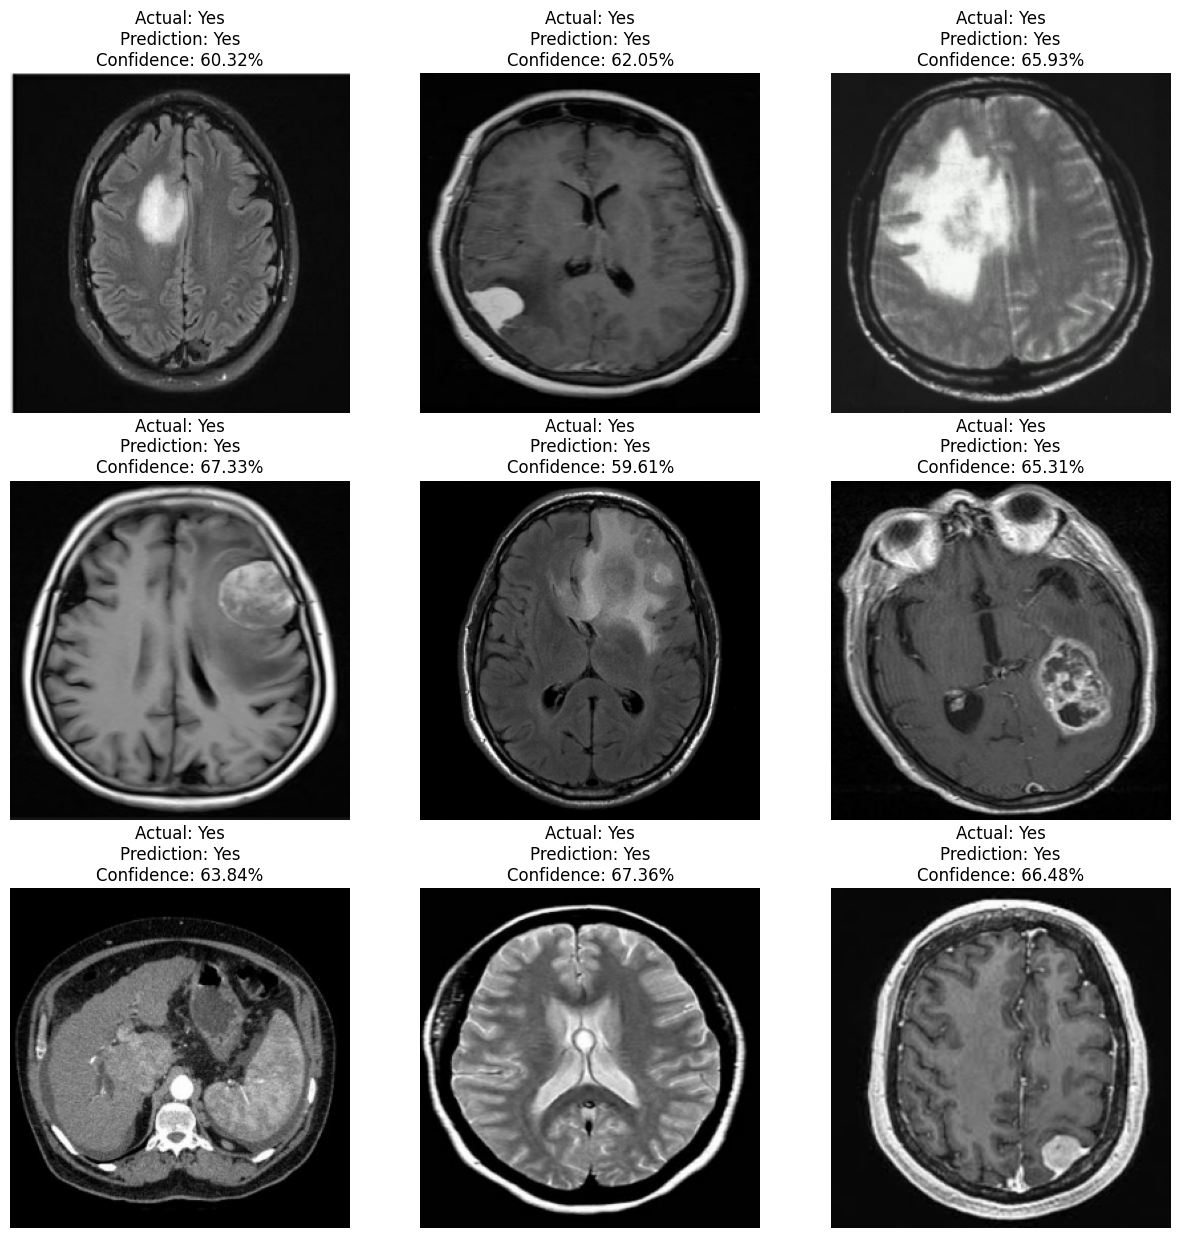

In [26]:
plt.figure(figsize=(15, 15))

for image_batch, label_batch in test_size.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = image_batch[i].numpy().astype('uint8')
        plt.imshow(img)
        
        prediction_class, confidence = predict(model, img)
        actual_label = classes_name[int(label_batch[i].numpy())]

        plt.title(f"Actual: {actual_label}\nPrediction: {prediction_class}\nConfidence: {confidence}%" )
        plt.axis('off')

In [27]:
import os 
model_version = max([int(i) for i in os.listdir("./sv_model")+ [0]]) +1
model.save(f"./sv_model/{model_version}")

INFO:tensorflow:Assets written to: ./sv_model/1\assets


INFO:tensorflow:Assets written to: ./sv_model/1\assets


In [28]:
model.save('./sv_model/my_model.h5')

In [29]:
import tensorflow as tf
import pickle

data_as_list = list(data.as_numpy_iterator())

with open('data.pkl', 'wb') as file:
    pickle.dump(data_as_list, file)


In [30]:
import tensorflow as tf
import pickle

data_as_list = list(data.as_numpy_iterator())

with open('model.pkl', 'wb') as file:
    pickle.dump(data_as_list, file)